In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [61]:
# https://blog.csdn.net/ling_mochen/article/details/80205419
raw = pd.read_csv('./data.csv')

print(raw.shape)

raw.head(5)

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,5


In [62]:
# 数据拆分为两部分，训练集 和 测试集
# 在这里将有标签的作为训练集，否则作为测试集

kobe = raw[pd.notnull(raw['shot_made_flag'])]
kobe.shape

(25697, 25)

Text(0.5, 1.0, 'lan and lon')

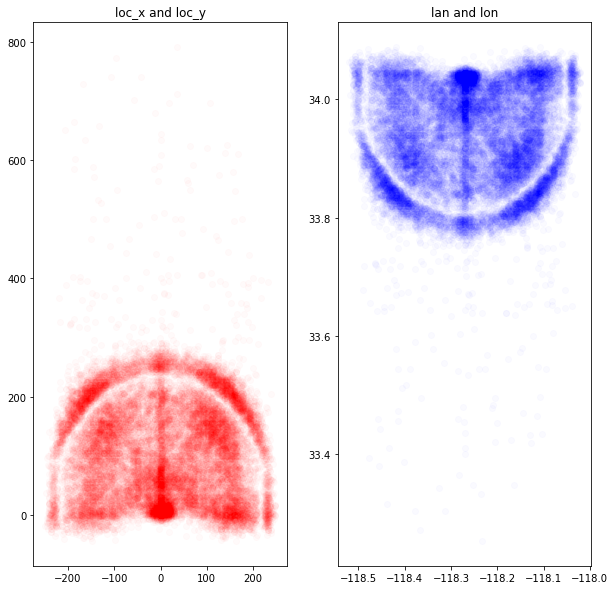

In [63]:
# 将投篮的位置信息画出来

alpha = 0.02 # 表示透明程度
plt.figure(figsize=(10, 10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(kobe.loc_x, kobe.loc_y, color = 'R', alpha=alpha)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(kobe.lon, kobe.lat, color = 'B', alpha=alpha)
plt.title('lan and lon')

In [64]:
# 从图中可以看出，特征间具有强相关性

In [65]:
# 需要将特征转换，转换为人或者机器更容易理解的数据
# 下面这两个，感觉像是将存在关系的特征，通过运算生成新的特征。不仅好理解还可以起到降维的作用
raw['dist'] = np.sqrt(raw['loc_x'] **2 + raw['loc_y'] **2)

loc_x_zero = raw['loc_x'] == 0
# print(loc_x_zero)

raw['angle'] = np.array([0] * len(raw))
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])
raw['angle'][loc_x_zero] = np.pi /2

raw['remaining_time'] = raw['minutes_remaining'] * 60 + raw['seconds_remaining']
raw.head(5)

<ipython-input-65-2cbb60718784>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])
<ipython-input-65-2cbb60718784>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['angle'][loc_x_zero] = np.pi /2


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,dist,angle,remaining_time
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,16-24 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,1,181.859836,0.407058,627
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,8-16 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,2,157.000000,-0.000000,622
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,16-24 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,3,168.600119,-0.928481,465
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,16-24 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,4,222.865430,0.903063,412
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000/10/31,LAL @ POR,POR,5,0.000000,1.570796,379


In [66]:
# 查看列中的不重复值
print(kobe.action_type.unique())
print(kobe.combined_shot_type.unique())
print(kobe.shot_type.unique())

# 每个类别的个数
print(kobe.shot_type.value_counts())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 'Putback Dun

In [67]:
kobe['season'].unique()

array(['Jan-00', 'Feb-01', 'Mar-02', 'Apr-03', 'May-04', 'Jun-05',
       'Jul-06', 'Aug-07', 'Sep-08', 'Oct-09', 'Nov-10', 'Dec-11',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [68]:
raw['season'] = raw['season'].apply(lambda x : int(x.split('-')[1]))
raw['season'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 97,
       98, 99], dtype=int64)

In [69]:
# 展示和哪个球队打球
pd.DataFrame({'matchup': kobe.matchup, 'opponent': kobe.opponent})

,matchup,opponent
1,LAL @ POR,POR
2,LAL @ POR,POR
3,LAL @ POR,POR
4,LAL @ POR,POR
5,LAL @ POR,POR
...,...,...
30691,LAL vs. IND,IND
30692,LAL vs. IND,IND
30694,LAL vs. IND,IND
30695,LAL vs. IND,IND


Text(0.5, 1.0, 'dist and shot_distance')

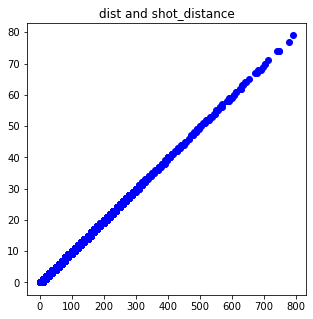

In [70]:
# 查看新增特征dist 和 shot_distance 是否相关  -- 图中可以看出，强线性相关
plt.figure(figsize=(5,5))

plt.scatter(raw.dist, raw.shot_distance, color = 'blue')
plt.title('dist and shot_distance')

In [71]:
gs = kobe.groupby('shot_zone_area')

print(kobe['shot_zone_area'].value_counts())
print(len(gs))

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64
6


Text(0.5, 1.0, 'shot_zone_range')

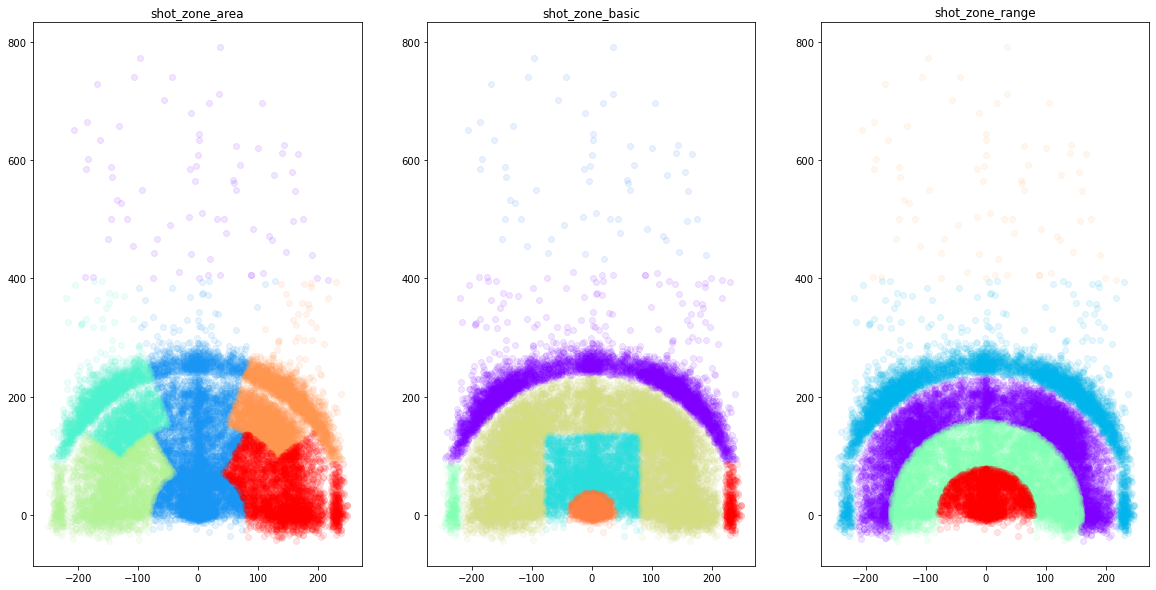

In [72]:
import matplotlib.cm as cm
plt.figure(figsize=(20, 10))

def scatter_plot_by_categroy(feat):
    alpha = 0.1
    
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color = c, alpha=alpha)
        
# shot_zone_area
plt.subplot(131)
scatter_plot_by_categroy('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_categroy('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_categroy('shot_zone_range')
plt.title('shot_zone_range')


In [73]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
        'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
        'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']

for drop in drops:
    raw = raw.drop(drop, 1)

raw.head(5)

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,remaining_time
0,Jump Shot,Jump Shot,1,0,0,NaN,2PT Field Goal,POR,181.859836,0.407058,627
1,Jump Shot,Jump Shot,1,0,0,0.0,2PT Field Goal,POR,157.000000,-0.000000,622
2,Jump Shot,Jump Shot,1,0,0,1.0,2PT Field Goal,POR,168.600119,-0.928481,465
3,Jump Shot,Jump Shot,1,0,0,0.0,2PT Field Goal,POR,222.865430,0.903063,412
4,Driving Dunk Shot,Dunk,2,0,0,1.0,2PT Field Goal,POR,0.000000,1.570796,379


In [74]:
# get_dummies用来做one-hot编码的
print(raw['combined_shot_type'].value_counts())
pd.get_dummies(raw['combined_shot_type'], prefix = 'combined_shot_type')[0:2]

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64


,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot
0,0,0,0,1,0,0
1,0,0,0,1,0,0


In [75]:
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']

for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)
    
raw

,playoffs,shot_made_flag,dist,angle,remaining_time,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,...,season_9,season_10,season_11,season_13,season_14,season_15,season_16,season_97,season_98,season_99
0,0,NaN,181.859836,0.407058,627,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,157.000000,-0.000000,622,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1.0,168.600119,-0.928481,465,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,222.865430,0.903063,412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.000000,1.570796,379,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,1,0.0,48.010416,1.549966,365,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30693,1,NaN,0.000000,1.570796,365,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30694,1,1.0,213.335417,-0.891663,208,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30695,1,0.0,268.793601,1.455209,130,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
train_kobe = raw[pd.notnull(raw['shot_made_flag'])]
train_kobe = train_kobe.drop('shot_made_flag', 1)
train_label = kobe['shot_made_flag']

test_kobe = raw[pd.isnull(raw['shot_made_flag'])]
test_kobe = test_kobe.drop('shot_made_flag', 1)

# print(train_kobe)
# test_kobe
train_label.iloc[20254]

0.0

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, log_loss
import time

import numpy as np

# 构造等比数列 -- 后续用于参数选择
range_m = np.logspace(0, 2, num = 5).astype(int)
range_m

array([  1,   3,  10,  31, 100])

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0, 2, num = 3).astype(int)

for n in range_n:
    print('the number of trees : {0}'.format(n))
    
    tl = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)
    
    fold = KFold(len(train_kobe), n_splits=10, shuffle=True)
    for train_k, test_k  in fold.split(train_kobe):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        
        pred = rfc.predict(train_kobe.iloc[test_k])
        print('值是：', [train_label.iloc[test_k[0]]])
        print('索引是：', test_k)
        print('预测值：', pred)
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
        
    scores_n.append(rfc_score)
    
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:3f} sec)'.format(n, t2 - t1))
    
print(best_n, min_score)

# github的一个案例

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


最优参数组合
	C:0.01
	class_weight:None
	dual:False
	fit_intercept:True
	intercept_scaling:1
	l1_ratio:None
	max_iter:100
	multi_class:'auto'
	n_jobs:None
	penalty:'l2'
	random_state:None
	solver:'lbfgs'
	tol:0.0001
	verbose:0
	warm_start:False
准确率： 0.6108949416342413
精确率： 0.628632938643703
召回率： 0.3358251868890167
 F1  ： 0.4377811094452774
 AUC ： 0.5863908543140736
              precision    recall  f1-score   support

         0.0       0.61      0.84      0.70      4232
         1.0       0.63      0.34      0.44      3478

    accuracy                           0.61      7710
   macro avg       0.62      0.59      0.57      7710
weighted avg       0.62      0.61      0.58      7710



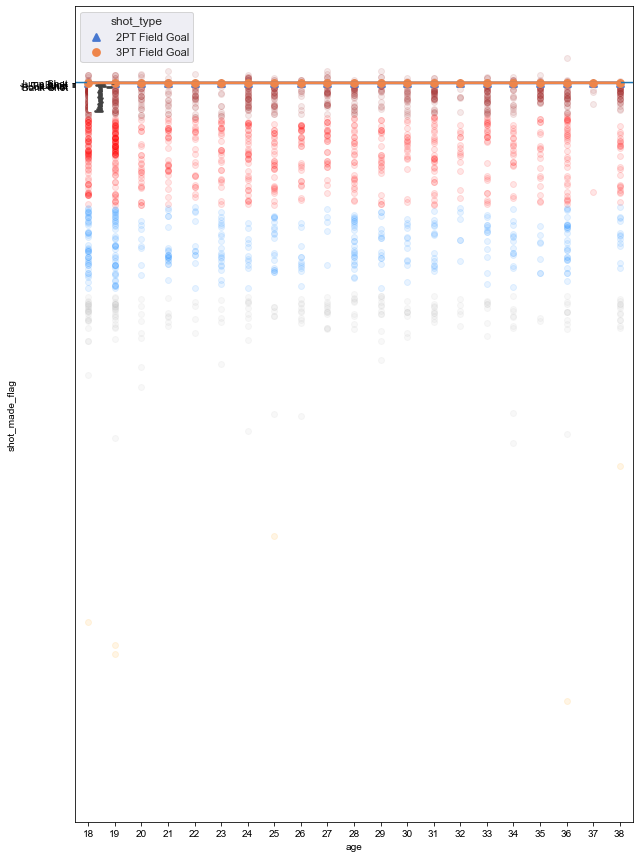

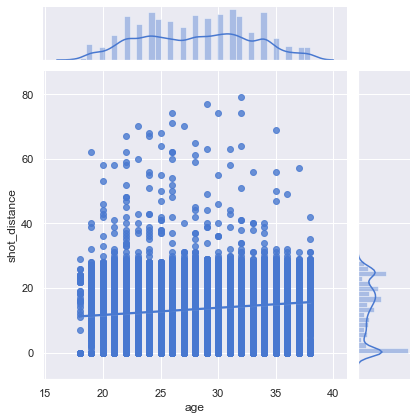

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 39044 missing from c

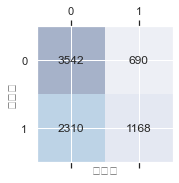

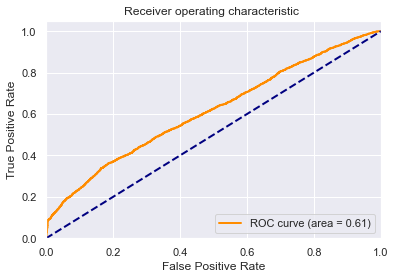

In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"] #解决plt乱码
plt.rcParams['axes.unicode_minus'] = False            #解决plt乱码
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,\
    precision_score, recall_score, accuracy_score,f1_score,roc_auc_score,\
    roc_curve,auc
#读入数据
data = pd.read_csv('data.csv')
data.head()

#删除没有用的列
dorp = ['action_type','game_event_id','game_id','team_id','team_name','matchup','shot_id','season']
data = data.drop(dorp,axis = 1)

#缺失值检查
data.isnull().sum()#返回每列包含的缺失值的个数
data = data.dropna()

#对数据进行预处理
data['opponent'].unique()
data.columns.tolist()
#计算科比年龄1978
data['age'] = data['game_date'].apply(lambda x: int(x.split('/')[0]))-1978
data = data.drop('game_date',axis = 1)

data['period'] = data['period'].astype('object')
data['shot_made_flag'].value_counts()
data.columns
data.dtypes
data.shape

#变量的可视化
#科比投篮
plt.figure(figsize=(10,15))
a = data.groupby('shot_zone_basic')
b = ['silver','orange','r','gold','dodgerblue','brown','gold']
for a1, b1 in zip(a,b):
    plt.scatter(a1[1].loc_x,a1[1].loc_y,color = b1 ,alpha=0.1)
#变量探索
import seaborn as sns
sns.set( palette="muted", color_codes=True) #设置图风格
sns.distplot(data.shot_distance,bins = 20)

sns.barplot(x=data.shot_zone_area,y=data.shot_made_flag)
sns.barplot(x=data.shot_type,y=data.shot_made_flag)
sns.barplot(x=data.shot_made_flag,y= data.opponent)
sns.barplot(x=data.shot_made_flag,y= data.combined_shot_type)

sns.pointplot(x=data.age,y= data.shot_made_flag,hue = data.shot_type,
              markers =['^','o'],linestyle =['-','--'] )

sns.jointplot(data.age,data.shot_distance, kind='reg')

#对自变量进行独热编码
data2 = pd.get_dummies(data.iloc[:,0:17])
data2.columns.tolist()

#构造模型数据集
data3 = data2.drop(['shot_made_flag'],axis = 1)
data3['label'] = data2['shot_made_flag']

#进行训练集与测试集的划分
data3.shape
X , y = data3.iloc[:,0:75].values , data3.iloc[:,-1].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state=1)

#使用逻辑回归
from sklearn.linear_model import LogisticRegression
clf = GridSearchCV(estimator=LogisticRegression(),
                  param_grid=[{'C':(0.01,0.1,1,10),
                               'penalty':('l1','l2')}],
                  scoring='roc_auc',
                  n_jobs = -1,
                  cv = 5)

# #使用SVM
# from sklearn.svm import SVC
# clf = GridSearchCV(estimator=SVC(max_iter = 50,probability = True),
#                   param_grid=[{'C':[0.001,0.01,0.1,1,10],
# 							   'kernel':['rbf','sigmoid']}],
#                   scoring='roc_auc',
#                   n_jobs=2,
#                   cv = 5)

# #使用决策树算法
# from sklearn import tree
# clf = GridSearchCV(estimator=tree.DecisionTreeClassifier(),
#                   param_grid=[{'criterion':('gini','entropy'),
# 	    					   'splitter':('best','random'),
# 							   'max_depth':range(3,8,1),
# 							   'min_samples_split':range(2,11,1),
# 							   'min_samples_leaf':range(2,11,1)}],
#                   scoring='roc_auc',
#                   n_jobs = -1,
#                   cv = 5)

# #使用随机森林
# from sklearn.ensemble import RandomForestClassifier
# clf = GridSearchCV(estimator=RandomForestClassifier(),
#                   param_grid=[{'n_estimators':range(10,100,10),
# 	    					   'criterion':('gini','entropy'),
# 							   'max_depth':range(3,8,1),
# 							   'min_samples_split':range(2,11,1),
# 							   'min_samples_leaf':range(2,11,1)}],
#                   scoring='roc_auc',
#                   n_jobs = -1,
#                   cv = 5)

# #使用GBDT
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GridSearchCV(estimator=GradientBoostingClassifier(),
#                    param_grid=[{'learning_rate':np.linspace(0.1,1.2,6),
# 							   'n_estimators':range(10,100,10),
# 	    					   'criterion':('friedman_mse','mse','mae'),
# 							   'max_depth':range(3,8,1),
# 							   'min_samples_split':range(2,11,1),
# 							   'min_samples_leaf':range(2,11,1)}],
#                    scoring='roc_auc',
#                    n_jobs=-1,
#                    cv = 5)

# #使用Adaboost
# from sklearn.ensemble import AdaBoostClassifier
# clf = GridSearchCV(estimator=AdaBoostClassifier(),
#                   param_grid=[{'learning_rate':np.linspace(0.1,1.2,6),
# 							   'n_estimators':range(10,100,10),
# 							   'algorithm':('SAMME','SAMME.R')}],
#                   scoring='roc_auc',
#                   n_jobs=-1,
#                   cv = 5)
				  
# #使用XGBoost
# from xgboost import XGBClassifier
# clf = GridSearchCV(estimator=XGBClassifier(),
#                   param_grid=[{'max_depth':range(3,9,1),
# 							   'gamma':[0.1,0.2],
# 							   'subsample':np.linspace(0.5,1,5),
#                                'colsample_bytree':np.linspace(0.5,1,5),
#                                'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#                                'learning_rate':[0.01,0.1,1]}],
#                   scoring='roc_auc',
#                   n_jobs=2,
#                   cv = 5)


clf.fit(X_train,y_train)
# 预测结果
y_pred_array = clf.predict(X_test)
y_pred_prob =clf.predict_proba(X_test)
print('最优参数组合')
best_parameters=clf.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s:%r' %(param_name,best_parameters[param_name]))

print('准确率：',accuracy_score(y_test,y_pred_array))
print('精确率：',precision_score(y_test,y_pred_array))
print('召回率：',recall_score(y_test,y_pred_array))
print(' F1  ：',f1_score(y_test,y_pred_array))
print(' AUC ：',roc_auc_score(y_test,y_pred_array))
#模型效果
print(classification_report( y_true=y_test, y_pred=y_pred_array ))
#画出混淆矩阵图
confmat = confusion_matrix( y_true=y_test, y_pred=y_pred_array )
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('预测值')
plt.ylabel('实际值')
plt.show()

#ROC曲线画图
fpr,tpr, _ = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

###########最后的模型效果图##############
# from sklearn.linear_model import LogisticRegression
# clf1 = LogisticRegression(C=0.1,class_weight=None,dual=False,fit_intercept=True,
# 	                     intercept_scaling=1,max_iter=100,multi_class='ovr',
#                          n_jobs=1,penalty='l1',random_state=None,solver='liblinear',
#                          tol=0.0001,verbose=0,warm_start=False)
# clf1.fit(X_train,y_train)
# y1_pred_prob =clf1.predict_proba(X_test)

# from sklearn.svm import SVC
# clf2 = SVC(C=0.10,cache_size=200,class_weight=None,coef0=0.0,decision_function_shape='ovr',
#            degree=3,gamma='auto',kernel='sigmoid',max_iter=50,probability=True,random_state=None,
# 		   shrinking=True,tol=0.001,verbose=False)
# clf2.fit(X_train,y_train)
# y2_pred_prob =clf2.predict_proba(X_test)		   

# from sklearn import tree
# clf3 = tree.DecisionTreeClassifier(class_weight=None,criterion='entropy',max_depth=6,max_features=None,
# 	                               max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,
#                                    min_samples_leaf=9,min_samples_split=3,min_weight_fraction_leaf=0.0,
# 	                               presort=False,random_state=None,splitter='random')
# clf3.fit(X_train,y_train)
# y3_pred_prob =clf3.predict_proba(X_test) 

# from sklearn.ensemble import RandomForestClassifier
# clf4 = RandomForestClassifier(bootstrap=True,class_weight=None,criterion='gini',max_depth=7,max_features='auto',
# 	                       max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=7,
# 	                       min_samples_split=8,min_weight_fraction_leaf=0.0,n_estimators=90,n_jobs=1,oob_score=False,
# 						   random_state=None,verbose=0,warm_start=False)
# clf4.fit(X_train,y_train)
# y4_pred_prob =clf4.predict_proba(X_test)   

# from sklearn.ensemble import AdaBoostClassifier
# clf5 = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=None,learning_rate=0.32,n_estimators=80,random_state=None)
# clf5.fit(X_train,y_train)
# y5_pred_prob =clf5.predict_proba(X_test) 

# from sklearn.ensemble import GradientBoostingClassifier
# clf6 = GradientBoostingClassifier(learning_rate=0.1,n_estimators=20,max_depth=3,min_samples_leaf=60,
#                                   min_samples_split =1000,max_features='sqrt',subsample=0.8,random_state=10)   
# clf6.fit(X_train,y_train)
# y6_pred_prob =clf6.predict_proba(X_test)   

# # from xgboost import XGBClassifier,plot_importance

# # clf7 = XGBClassifier(base_score=0.5,booster='gbtree',colsample_bylevel=1,colsample_bytree=1,gamma=0.1,
# # 	                 learning_rate=0.1,max_delta_step=0,max_depth=5,min_child_weight=1,missing=None,
# # 					 n_estimators=100,n_jobs=1,nthread=None,objective='binary:logistic',random_state=0,
# # 					 reg_alpha=0,reg_lambda=1,scale_pos_weight=1,seed=None,silent=True,subsample=1)
# # clf7.fit(X_train,y_train)
# # y7_pred_prob =clf7.predict_proba(X_test)

# #ROC曲线画图
# plt.figure()
# list = [y1_pred_prob,y2_pred_prob,y3_pred_prob,y4_pred_prob,
#         y5_pred_prob,y6_pred_prob,y7_pred_prob]
# list2 = ['LR','SVM','DT','RF','Ada','GBDT','XGB']
# list3 = ['k','r','y','c','g','b','m']
# # for i in [0,1,2,3,4,5,6]:
# for i in [0,1,2,3,4,5]:
#     fpr,tpr, _ = roc_curve(y_test, list[i][:,1])
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot(fpr, tpr, color=list3[i],
#          lw=lw, label='%s ROC curve (area = %0.2f)' % (list2[i],roc_auc))
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic ')
#     plt.legend(loc="lower right")
#     plt.show()

# #变量重要性
# import matplotlib.pyplot as plt
# ax=plot_importance(clf7,max_num_features = 20)
# plt.show()  #没有这句只有debug模式才会显示。。
# help(plot_importance)